# Hypothesis Testing: Response Time's Impact on Online Purchase Intention

## 1. Introduction

This notebook implements a comprehensive analysis of Hypothesis 9: "Response Time has no impact on intention to purchase online." Response time refers to how quickly an e-commerce platform responds to user actions, which could be a critical factor influencing purchase decisions during online shopping experiences.

## 2. Setting up the Environment



In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14



## 3. Data Loading and Preparation



In [55]:
# Load the dataset
df = pd.read_csv('../../data/cleaned/cleaned_survey_data.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of responses: {len(df)}")

# Check for missing values in key columns
response_cols = ['peou_response_1', 'peou_response_2']
intention_cols = ['opi_satisfaction', 'opi_behavior_change', 'opi_convenience', 'opi_value']

missing_data = pd.DataFrame({
    'Missing Values': df[response_cols + intention_cols].isnull().sum(),
    'Percentage': df[response_cols + intention_cols].isnull().sum() / len(df) * 100
})

print("\nMissing values in key columns:")
print(missing_data)



Dataset shape: (825, 137)
Number of responses: 825

Missing values in key columns:
                     Missing Values  Percentage
peou_response_1                   0         0.0
peou_response_2                   0         0.0
opi_satisfaction                  0         0.0
opi_behavior_change               0         0.0
opi_convenience                   0         0.0
opi_value                         0         0.0




## 4. Exploratory Data Analysis




Basic statistics for response time variables:
       peou_response_1  peou_response_2
count       825.000000       825.000000
mean          3.215758         2.898182
std           0.781767         0.711766
min           1.000000         1.000000
25%           3.000000         3.000000
50%           3.000000         3.000000
75%           4.000000         3.000000
max           5.000000         5.000000

Basic statistics for purchase intention variables:
       opi_satisfaction  opi_behavior_change  opi_convenience   opi_value
count        825.000000           825.000000        825.00000  825.000000
mean           3.743030             3.904242          3.84000    3.780606
std            0.818122             0.713459          0.73147    0.759479
min            1.000000             1.000000          1.00000    1.000000
25%            3.000000             4.000000          3.00000    3.000000
50%            4.000000             4.000000          4.00000    4.000000
75%            4.000000

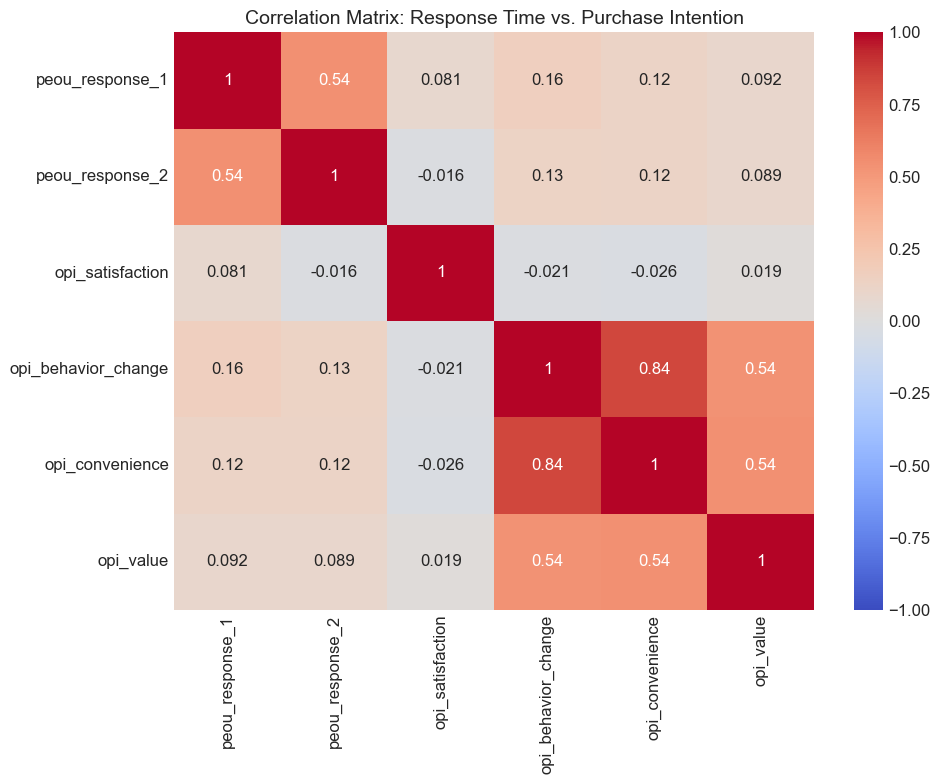


Response Time Variables Description:
peou_response_1: 'The online platform responds quickly to my actions, such as loading pages and processing transactions.'
peou_response_2: 'I don't experience delays or long waiting times when using the online platform for making online purchases during a crisis.'

Note: Higher values (1-5) indicate better (faster) response time perception

Reliability Analysis:
Correlation between response time measures: 0.5433
This indicates moderate reliability of our response time measure.

Correlation of response time with specific purchase intention aspects:
opi_satisfaction: r = 0.0397, p = 0.2543 
opi_behavior_change: r = 0.1646, p = 0.0000 (significant)
opi_convenience: r = 0.1378, p = 0.0001 (significant)
opi_value: r = 0.1030, p = 0.0030 (significant)


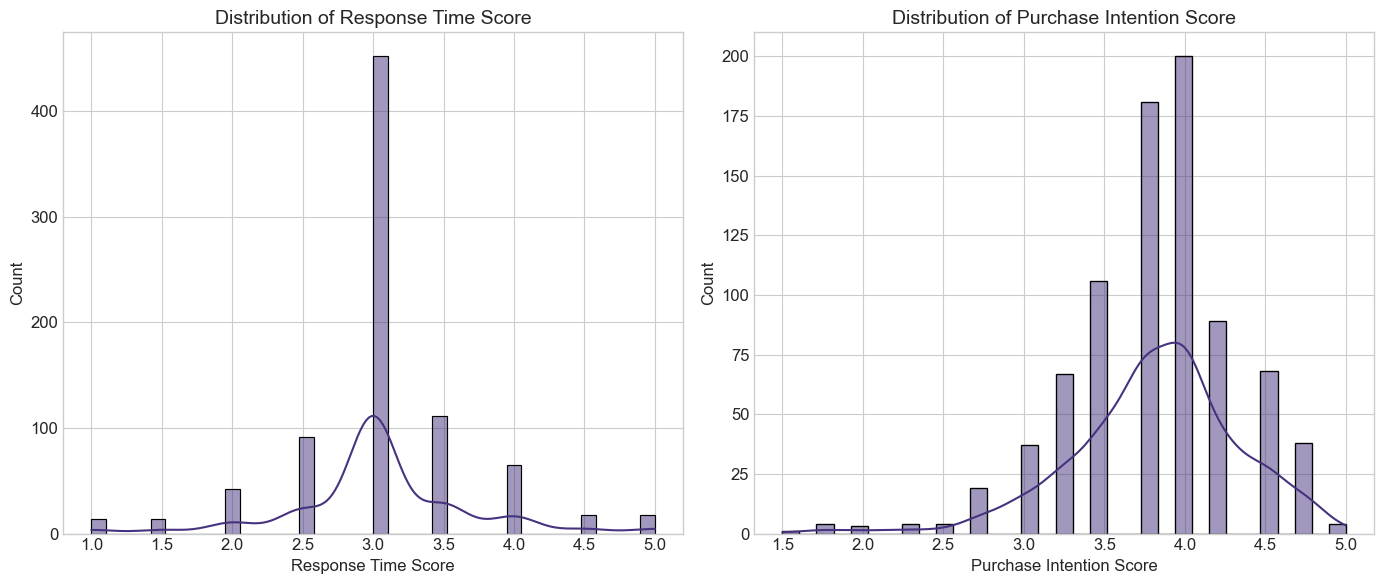

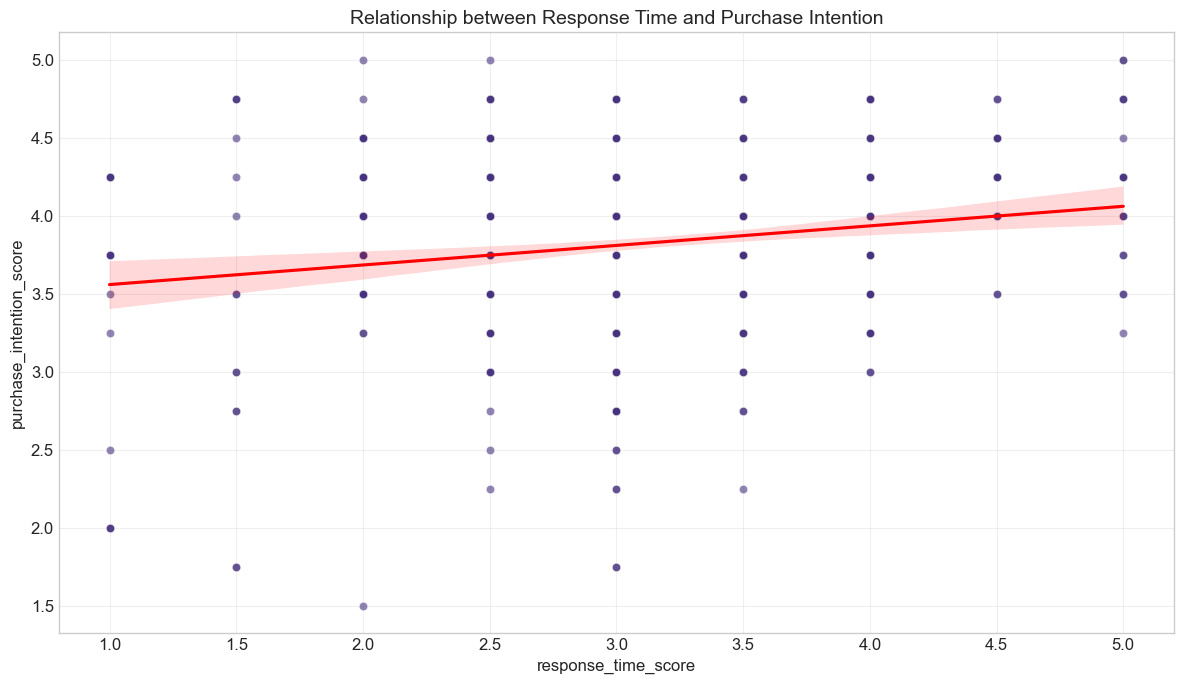

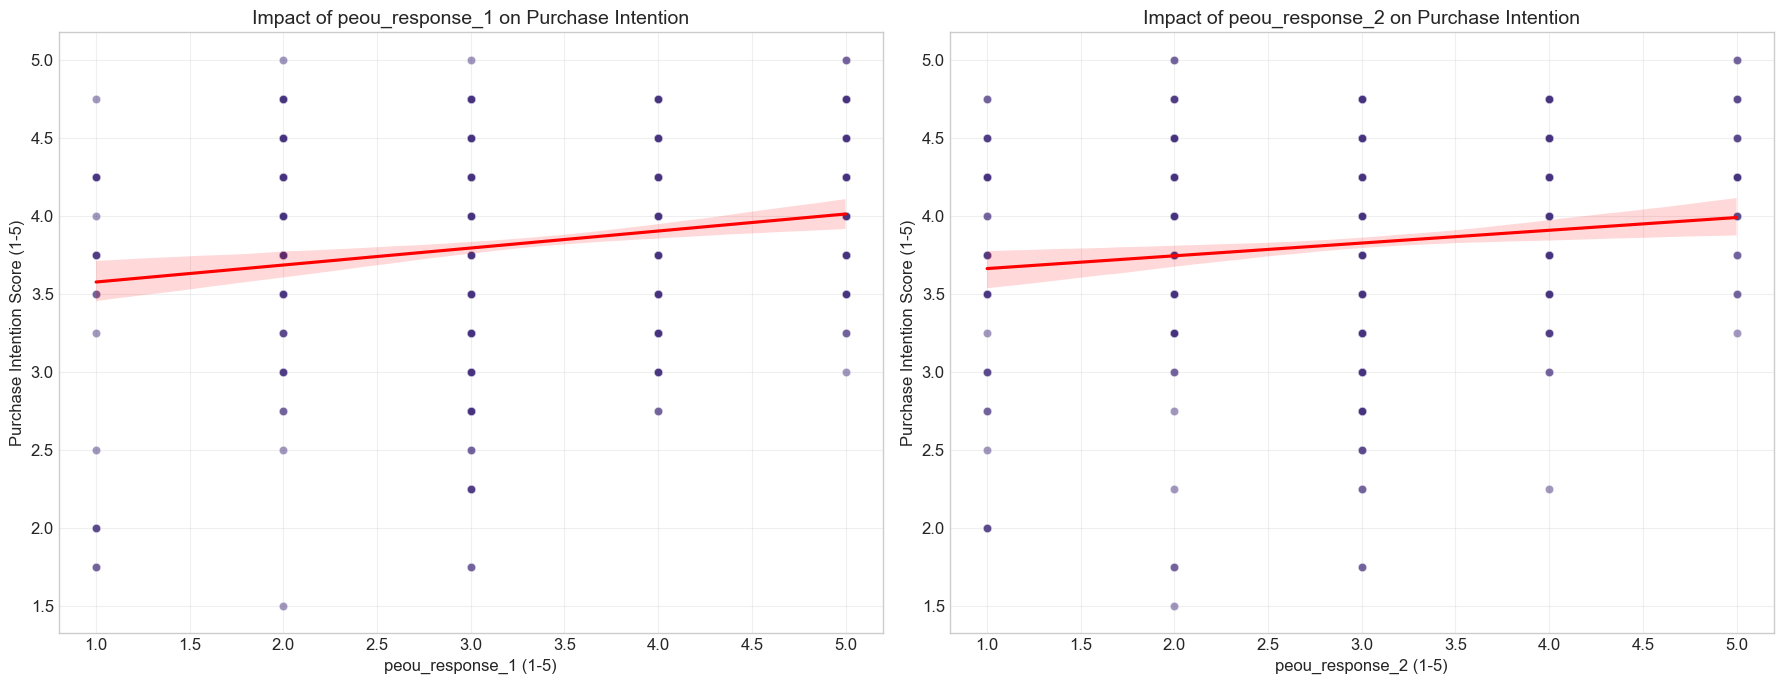

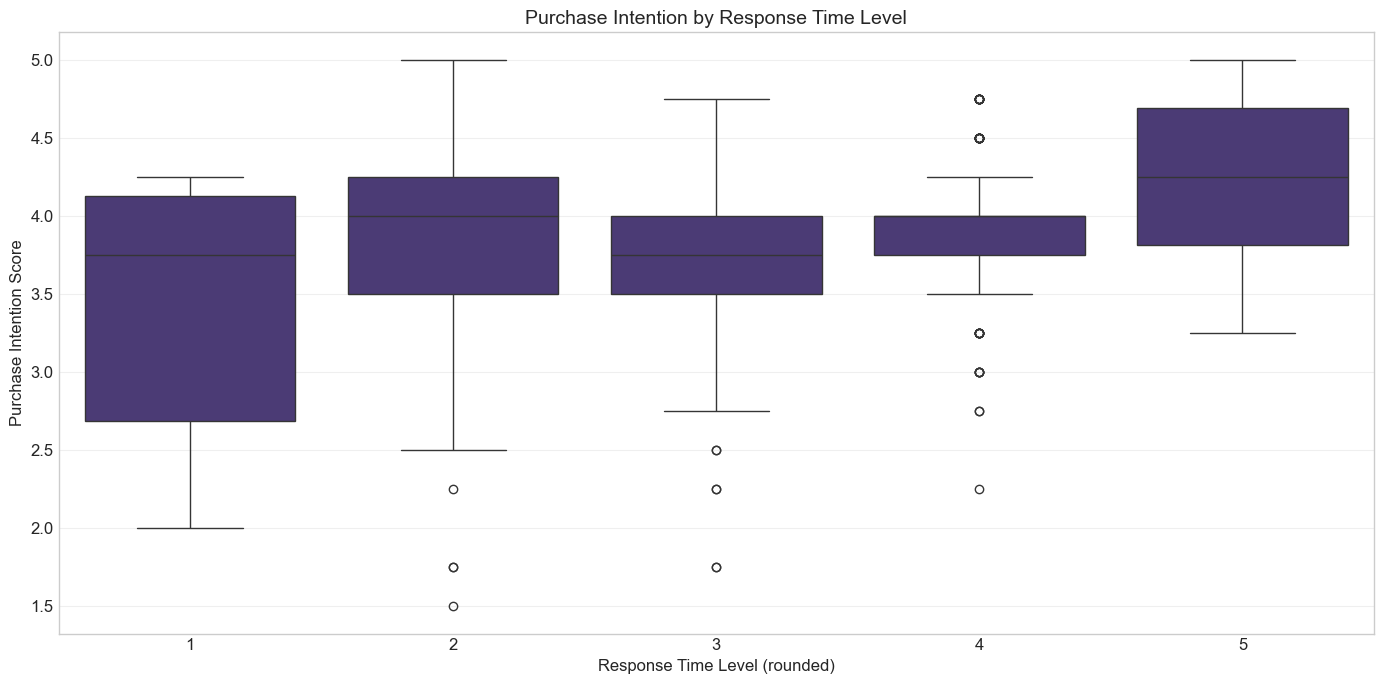

In [56]:
# Display basic statistics for response time and purchase intention variables
print("\nBasic statistics for response time variables:")
print(df[response_cols].describe())

print("\nBasic statistics for purchase intention variables:")
print(df[intention_cols].describe())

# Create a correlation matrix for response time and purchase intention variables
corr_matrix = df[response_cols + intention_cols].corr()
print("\nCorrelation matrix:")
print(corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: Response Time vs. Purchase Intention')
plt.tight_layout()
plt.show()

# Create a composite response time score (average of both response time variables)
df['response_time_score'] = df[response_cols].mean(axis=1)

# Create a composite purchase intention score (average of intention variables)
df['purchase_intention_score'] = df[intention_cols].mean(axis=1)

# Add context for the response time variables
print("\nResponse Time Variables Description:")
print("peou_response_1: 'The online platform responds quickly to my actions, such as loading pages and processing transactions.'")
print("peou_response_2: 'I don't experience delays or long waiting times when using the online platform for making online purchases during a crisis.'")
print("\nNote: Higher values (1-5) indicate better (faster) response time perception")

# Examine reliability of the composite scores
print("\nReliability Analysis:")
rt_reliability = np.corrcoef(df['peou_response_1'], df['peou_response_2'])[0,1]
print(f"Correlation between response time measures: {rt_reliability:.4f}")
print(f"This indicates {'high' if rt_reliability > 0.7 else 'moderate' if rt_reliability > 0.5 else 'low'} reliability of our response time measure.")

# Calculate specific purchase intention aspects' correlation with response time
print("\nCorrelation of response time with specific purchase intention aspects:")
for col in intention_cols:
    corr, p = stats.pearsonr(df['response_time_score'], df[col])
    print(f"{col}: r = {corr:.4f}, p = {p:.4f} {'(significant)' if p < 0.05 else ''}")

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot distribution of response time score
sns.histplot(df['response_time_score'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Response Time Score')
axes[0].set_xlabel('Response Time Score')

# Plot distribution of purchase intention score
sns.histplot(df['purchase_intention_score'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Purchase Intention Score')
axes[1].set_xlabel('Purchase Intention Score')

plt.tight_layout()
plt.show()

# Visualize the relationship between response time and purchase intention
plt.figure(figsize=(12, 7))
sns.scatterplot(x='response_time_score', y='purchase_intention_score', data=df, alpha=0.6)
plt.title('Relationship between Response Time and Purchase Intention')
plt.xlabel('Response Time Score (1-5)')
plt.ylabel('Purchase Intention Score (1-5)')

# Add regression line
sns.regplot(x='response_time_score', y='purchase_intention_score', data=df, 
            scatter=False, line_kws={"color": "red"})

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Examine individual response time variables and their relationship with intention
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for i, col in enumerate(response_cols):
    sns.scatterplot(x=col, y='purchase_intention_score', data=df, ax=axes[i], alpha=0.5)
    sns.regplot(x=col, y='purchase_intention_score', data=df, ax=axes[i], 
                scatter=False, line_kws={"color": "red"})
    axes[i].set_title(f'Impact of {col} on Purchase Intention')
    axes[i].set_xlabel(f'{col} (1-5)')
    axes[i].set_ylabel('Purchase Intention Score (1-5)')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create boxplots for different response time levels and their effect on purchase intention
plt.figure(figsize=(14, 7))
response_levels = df['response_time_score'].round().astype(int)
sns.boxplot(x=response_levels, y='purchase_intention_score', data=df)
plt.title('Purchase Intention by Response Time Level')
plt.xlabel('Response Time Level (rounded)')
plt.ylabel('Purchase Intention Score')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.1 Reliability Analysis of Response Time Measures 

In [57]:
# Add this to cell 4 (EDA) or as a new cell after it

print("\n### 4.1 Reliability Analysis of Response Time Measures ###")

# Calculate Cronbach's alpha for response time variables
from sklearn.preprocessing import scale

# If more than 2 response time variables, calculate Cronbach's alpha
if len(response_cols) > 1:
    # Standardize variables
    z_scores = scale(df[response_cols])
    
    # Calculate item-total correlations
    total_scores = z_scores.sum(axis=1)
    item_total_corrs = [np.corrcoef(z_scores[:, i], total_scores - z_scores[:, i])[0, 1] 
                        for i in range(z_scores.shape[1])]
    
    # Calculate average inter-item correlation
    inter_item_corrs = []
    for i in range(len(response_cols)):
        for j in range(i+1, len(response_cols)):
            inter_item_corrs.append(np.corrcoef(df[response_cols[i]], df[response_cols[j]])[0, 1])
    avg_inter_item_corr = np.mean(inter_item_corrs)
    
    # Calculate Cronbach's alpha
    n_items = len(response_cols)
    cronbach_alpha = (n_items * avg_inter_item_corr) / (1 + (n_items - 1) * avg_inter_item_corr)
    
    print(f"Cronbach's alpha for response time measures: {cronbach_alpha:.4f}")
    print(f"Average inter-item correlation: {avg_inter_item_corr:.4f}")
    print("\nItem-Total Correlations:")
    for i, col in enumerate(response_cols):
        print(f"{col}: {item_total_corrs[i]:.4f}")
    
    # Interpret reliability
    if cronbach_alpha >= 0.9:
        print("\nInterpretation: Excellent reliability (α ≥ 0.9)")
    elif cronbach_alpha >= 0.8:
        print("\nInterpretation: Good reliability (0.8 ≤ α < 0.9)")
    elif cronbach_alpha >= 0.7:
        print("\nInterpretation: Acceptable reliability (0.7 ≤ α < 0.8)")
    elif cronbach_alpha >= 0.6:
        print("\nInterpretation: Questionable reliability (0.6 ≤ α < 0.7)")
    elif cronbach_alpha >= 0.5:
        print("\nInterpretation: Poor reliability (0.5 ≤ α < 0.6)")
    else:
        print("\nInterpretation: Unacceptable reliability (α < 0.5)")


### 4.1 Reliability Analysis of Response Time Measures ###
Cronbach's alpha for response time measures: 0.7041
Average inter-item correlation: 0.5433

Item-Total Correlations:
peou_response_1: 0.5433
peou_response_2: 0.5433

Interpretation: Acceptable reliability (0.7 ≤ α < 0.8)




## 5. Hypothesis Testing

### 5.1 Pearson Correlation Test



In [58]:
# Calculate Pearson correlation between response time and purchase intention
correlation, p_value = stats.pearsonr(df['response_time_score'], df['purchase_intention_score'])

print("Pearson Correlation Test Results:")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.6f}")

# Determine statistical significance
alpha = 0.05
if p_value < alpha:
    print(f"The correlation is statistically significant (p < {alpha}).")
    print("Reject the null hypothesis: Response time has an impact on purchase intention.")
else:
    print(f"The correlation is not statistically significant (p > {alpha}).")
    print("Fail to reject the null hypothesis: No evidence that response time impacts purchase intention.")

Pearson Correlation Test Results:
Correlation coefficient: 0.1584
P-value: 0.000005
The correlation is statistically significant (p < 0.05).
Reject the null hypothesis: Response time has an impact on purchase intention.


### Power Analysis to the Correlation Test

In [59]:
# Replace the current power analysis code with this more appropriate approach for correlation
from statsmodels.stats.power import TTestPower

# Minimum effect size of interest (e.g., r = 0.2 for a small-to-medium effect)
min_effect_size = 0.2

# Convert correlation to equivalent t-statistic for power analysis
t_stat = correlation * np.sqrt((len(df) - 2) / (1 - correlation**2))

# Calculate power using t-test approach (appropriate for Pearson correlation)
power_analysis = TTestPower()
# Use nobs-2 for degrees of freedom in correlation test
achieved_power = power_analysis.power(effect_size=abs(t_stat)/np.sqrt(len(df)), 
                                     nobs=len(df), 
                                     alpha=alpha)

# Calculate required sample size for detecting the minimum effect size with 80% power
# Convert min correlation to equivalent effect size
min_t_effect = min_effect_size * np.sqrt((200 - 2) / (1 - min_effect_size**2)) / np.sqrt(200)
required_n = power_analysis.solve_power(effect_size=min_t_effect, 
                                       power=0.8, 
                                       alpha=alpha)

print("\nStatistical Power Analysis:")
print(f"Achieved power for detected correlation (r = {correlation:.3f}): {achieved_power:.3f}")
print(f"Required sample size to detect r = {min_effect_size} with 80% power: {int(required_n)}")

if achieved_power < 0.8:
    print("Warning: The analysis may be underpowered. Interpret non-significant results cautiously.")
else:
    print("The analysis has adequate statistical power.")


Statistical Power Analysis:
Achieved power for detected correlation (r = 0.158): 0.996
Required sample size to detect r = 0.2 with 80% power: 192
The analysis has adequate statistical power.




### 5.2 Simple Linear Regression



In [60]:
# Perform simple linear regression
X = df['response_time_score'].values.reshape(-1, 1)
y = df['purchase_intention_score']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nSimple Linear Regression Results:")
print(f"Coefficient (Slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# Create a more detailed model using statsmodels for better statistical insights
X_with_const = sm.add_constant(df['response_time_score'])
sm_model = sm.OLS(df['purchase_intention_score'], X_with_const).fit()

print("\nDetailed Regression Results:")
print(sm_model.summary())

# Interpret the results
print("\nRegression Interpretation:")
if sm_model.pvalues[1] < 0.05:
    print("The relationship between response time and purchase intention is statistically significant.")
    print(f"For every 1-unit increase in response time score, purchase intention increases by {sm_model.params[1]:.4f} units.")
    print("This suggests that faster response time (higher score) positively impacts purchase intention.")
    print("We reject the null hypothesis: Response time has a significant impact on intention to purchase online.")
else:
    print("The relationship between response time and purchase intention is not statistically significant.")
    print("We fail to reject the null hypothesis: No evidence that response time impacts intention to purchase online.")


Simple Linear Regression Results:
Coefficient (Slope): 0.1221
Intercept: 3.4552
R-squared: 0.0148
Root Mean Squared Error: 0.4999

Detailed Regression Results:
                               OLS Regression Results                               
Dep. Variable:     purchase_intention_score   R-squared:                       0.025
Model:                                  OLS   Adj. R-squared:                  0.024
Method:                       Least Squares   F-statistic:                     21.18
Date:                      Fri, 09 May 2025   Prob (F-statistic):           4.85e-06
Time:                              21:47:08   Log-Likelihood:                -619.09
No. Observations:                       825   AIC:                             1242.
Df Residuals:                           823   BIC:                             1252.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                               

### 5.2.1 Non-Linear Relationship Testing 


### 5.2.1 Non-Linear Relationship Testing ###
Polynomial Regression Results:
                               OLS Regression Results                               
Dep. Variable:     purchase_intention_score   R-squared:                       0.028
Model:                                  OLS   Adj. R-squared:                  0.026
Method:                       Least Squares   F-statistic:                     12.03
Date:                      Fri, 09 May 2025   Prob (F-statistic):           7.12e-06
Time:                              21:47:08   Log-Likelihood:                -617.68
No. Observations:                       825   AIC:                             1241.
Df Residuals:                           822   BIC:                             1256.
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      

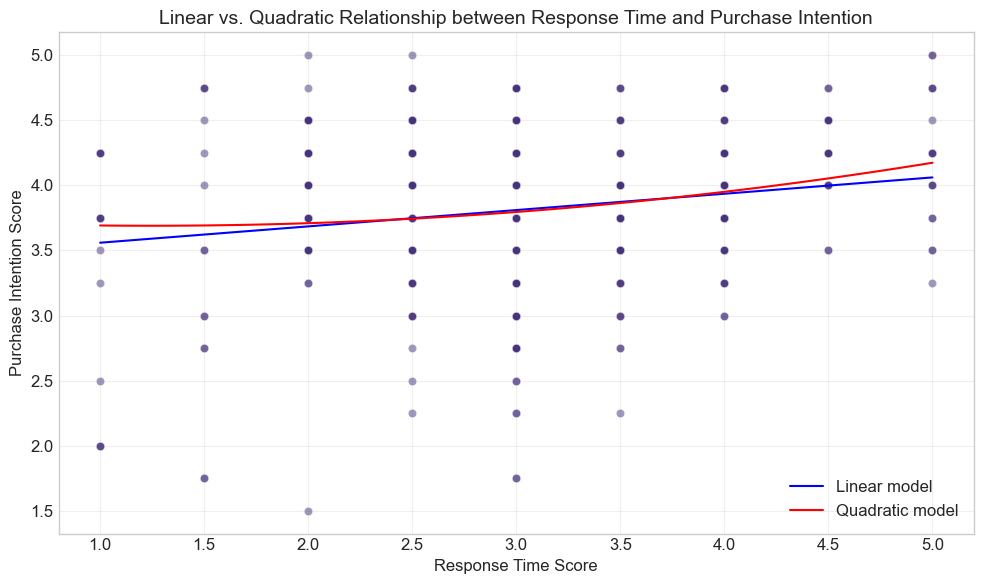

In [61]:
# Add this cell after cell 5.2 (Simple Linear Regression)

# Test for non-linear relationships
print("\n### 5.2.1 Non-Linear Relationship Testing ###")

# Create polynomial features
X_poly = df['response_time_score'].values.reshape(-1, 1)
X_poly_squared = np.column_stack((X_poly, X_poly**2))
X_poly_with_const = sm.add_constant(X_poly_squared)

# Fit quadratic model
poly_model = sm.OLS(df['purchase_intention_score'], X_poly_with_const).fit()

print("Polynomial Regression Results:")
print(poly_model.summary())

# Compare models
print("\nModel Comparison:")
print(f"Linear R-squared: {sm_model.rsquared:.4f}")
print(f"Quadratic R-squared: {poly_model.rsquared:.4f}")
print(f"R-squared improvement: {poly_model.rsquared - sm_model.rsquared:.4f}")

# Test if the improvement is significant
if poly_model.pvalues[2] < 0.05:
    print(f"The quadratic term is significant (p = {poly_model.pvalues[2]:.4f})")
    print("The relationship between response time and purchase intention is non-linear.")
    
    # Interpret the direction
    if poly_model.params[2] > 0:
        print("The positive quadratic term indicates that the effect accelerates at higher response time values.")
    else:
        print("The negative quadratic term indicates diminishing returns at higher response time values.")
else:
    print(f"The quadratic term is not significant (p = {poly_model.pvalues[2]:.4f})")
    print("No evidence of a non-linear relationship. The linear model is sufficient.")

# Visualize both models
plt.figure(figsize=(10, 6))
sns.scatterplot(x='response_time_score', y='purchase_intention_score', data=df, alpha=0.5)

# Add linear regression line
x_range = np.linspace(df['response_time_score'].min(), df['response_time_score'].max(), 100)
y_linear = sm_model.params[0] + sm_model.params[1] * x_range
plt.plot(x_range, y_linear, color='blue', label='Linear model')

# Add polynomial regression curve
y_poly = poly_model.params[0] + poly_model.params[1] * x_range + poly_model.params[2] * x_range**2
plt.plot(x_range, y_poly, color='red', label='Quadratic model')

plt.title('Linear vs. Quadratic Relationship between Response Time and Purchase Intention')
plt.xlabel('Response Time Score')
plt.ylabel('Purchase Intention Score')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 5.2.2 Robust Regression Analysis

In [62]:
# Add this cell after the non-linear testing cell

# Perform robust regression to handle potential outliers
print("\n### 5.2.2 Robust Regression Analysis ###")

import statsmodels.formula.api as smf
from statsmodels.robust.robust_linear_model import RLM

# Fit robust regression model (Huber's T)
X_robust = sm.add_constant(df['response_time_score'])
robust_model = RLM(df['purchase_intention_score'], X_robust, M=sm.robust.norms.HuberT()).fit()

print("Robust Regression Results:")
print(robust_model.summary())
print(f"Robust coefficient: {robust_model.params[1]:.4f}")

# Compare with OLS
print("\nComparing OLS vs. Robust Regression:")
print(f"OLS coefficient: {sm_model.params[1]:.4f}")
print(f"Robust coefficient: {robust_model.params[1]:.4f}")
print(f"Difference: {abs(sm_model.params[1] - robust_model.params[1]):.4f}")

if abs(sm_model.params[1] - robust_model.params[1]) > 0.05:
    print("The substantial difference between OLS and robust regression suggests outliers may be influencing the results.")
else:
    print("OLS and robust regression give similar results, suggesting outliers are not significantly impacting the analysis.")


### 5.2.2 Robust Regression Analysis ###
Robust Regression Results:
                       Robust linear Model Regression Results                       
Dep. Variable:     purchase_intention_score   No. Observations:                  825
Model:                                  RLM   Df Residuals:                      823
Method:                                IRLS   Df Model:                            1
Norm:                                HuberT                                         
Scale Est.:                             mad                                         
Cov Type:                                H1                                         
Date:                      Fri, 09 May 2025                                         
Time:                              21:47:08                                         
No. Iterations:                          19                                         
                          coef    std err          z      P>|z|      [0.025      

### 5.2.3 Regression Diagnostics


### 5.2.3 Regression Diagnostics ###


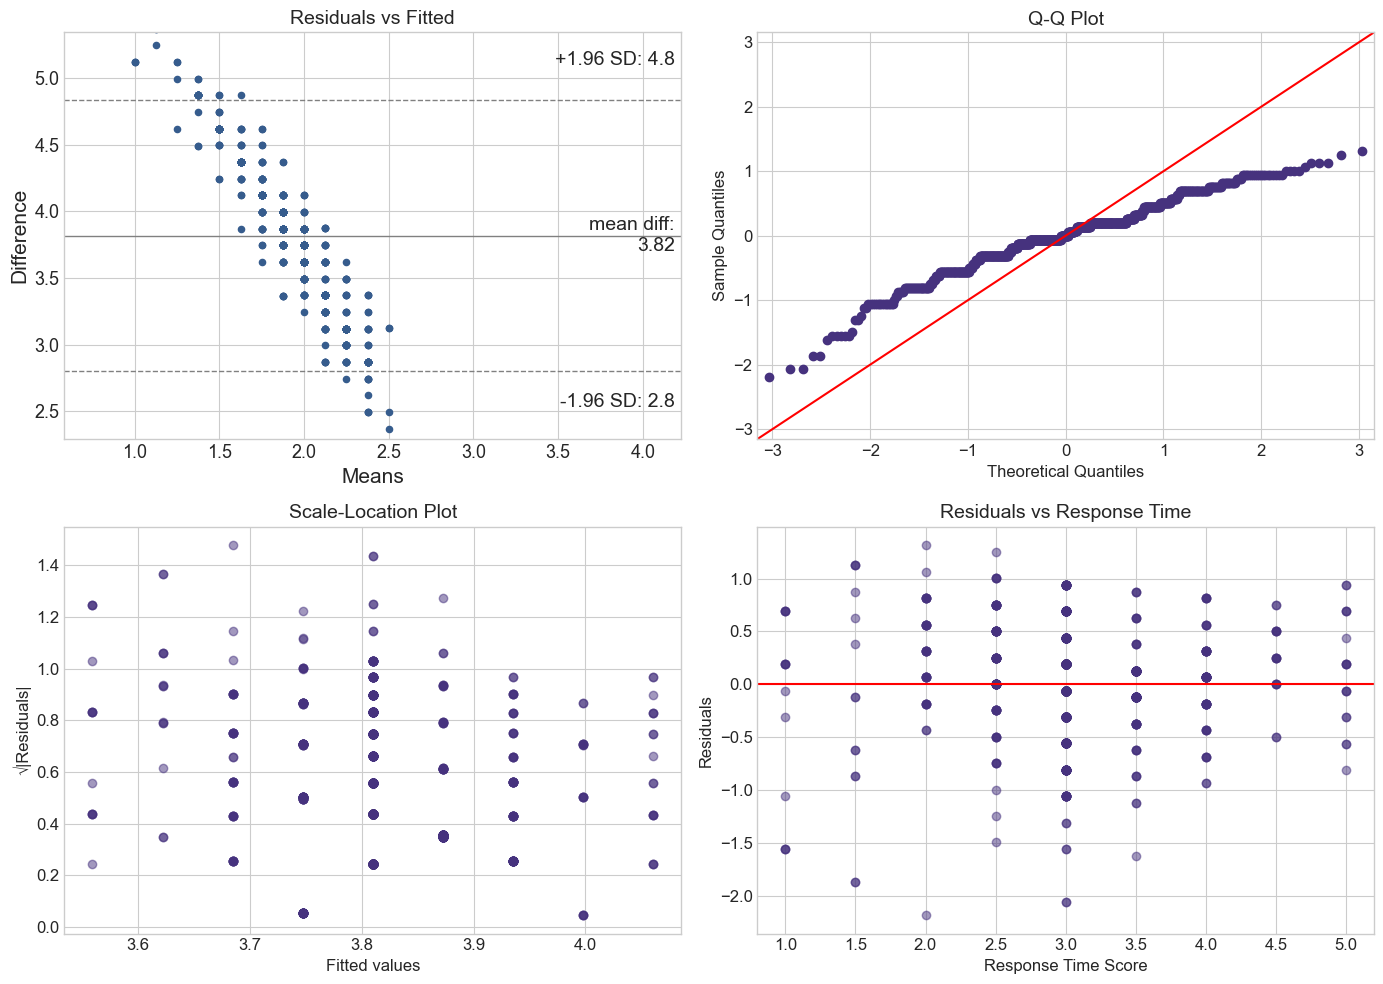


Breusch-Pagan test for heteroscedasticity:
LM statistic: 32.9412
p-value: 0.000000
Conclusion: Heteroscedasticity present

D'Agostino-Pearson test for normality of residuals:
K2 statistic: 62.5063
p-value: 0.000000
Conclusion: Residuals are not normally distributed


In [63]:
# Add this cell after cell 5.2 (Simple Linear Regression)

# Residual analysis to check regression assumptions
print("\n### 5.2.3 Regression Diagnostics ###")

# Get residuals
residuals = sm_model.resid
fitted_values = sm_model.fittedvalues

# Create a 2x2 plot for residual diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
axes[0, 0].scatter(fitted_values, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='-')
axes[0, 0].set_xlabel('Fitted values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')
sm.graphics.mean_diff_plot(fitted_values, residuals, ax=axes[0, 0])

# 2. Q-Q plot
sm.qqplot(residuals, line='45', ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot')

# 3. Scale-Location Plot
sqrt_abs_resid = np.sqrt(np.abs(residuals))
axes[1, 0].scatter(fitted_values, sqrt_abs_resid, alpha=0.5)
axes[1, 0].set_xlabel('Fitted values')
axes[1, 0].set_ylabel('√|Residuals|')
axes[1, 0].set_title('Scale-Location Plot')

# 4. Residuals vs Response Time
axes[1, 1].scatter(df['response_time_score'], residuals, alpha=0.5)
axes[1, 1].axhline(y=0, color='r', linestyle='-')
axes[1, 1].set_xlabel('Response Time Score')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residuals vs Response Time')

plt.tight_layout()
plt.show()

# Test for homoscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(residuals, sm_model.model.exog)
print(f"\nBreusch-Pagan test for heteroscedasticity:")
print(f"LM statistic: {bp_test[0]:.4f}")
print(f"p-value: {bp_test[1]:.6f}")
print(f"Conclusion: {'Heteroscedasticity present' if bp_test[1] < 0.05 else 'Homoscedasticity assumption satisfied'}")

# Test for normality of residuals
from scipy import stats

k2, p_value = stats.normaltest(residuals)
print(f"\nD'Agostino-Pearson test for normality of residuals:")
print(f"K2 statistic: {k2:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Conclusion: {'Residuals are not normally distributed' if p_value < 0.05 else 'Residuals are normally distributed'}")



### 5.3 Multiple Linear Regression (Using Both Response Time Variables)



In [64]:
# Perform multiple linear regression with both response time variables
X_multi = df[response_cols]
y_multi = df['purchase_intention_score']

# Add a constant
X_multi_with_const = sm.add_constant(X_multi)

# Fit the model
multi_model = sm.OLS(y_multi, X_multi_with_const).fit()

print("\nMultiple Linear Regression Results:")
print(multi_model.summary())

# Check for significance of individual predictors
print("\nSignificance of Individual Response Time Variables:")
for i, var in enumerate(response_cols, 1):
    p_val = multi_model.pvalues[i]
    coef = multi_model.params[i]
    print(f"{var}: Coefficient = {coef:.4f}, p-value = {p_val:.6f}, {'Significant' if p_val < 0.05 else 'Not Significant'}")

# Calculate partial correlations
# Calculate partial correlations
print("\nPartial Correlations:")
for col in response_cols:
    others = [c for c in response_cols if c != col]
    
    # Include both original intention columns and the composite score
    X_partial = df[others + intention_cols + ['purchase_intention_score']].copy()
    
    # Regress X on other predictors
    X_partial_with_const = sm.add_constant(X_partial[others])
    model_X = sm.OLS(df[col], X_partial_with_const).fit()
    residuals_X = model_X.resid
    
    # Regress Y on other predictors
    model_Y = sm.OLS(X_partial['purchase_intention_score'], X_partial_with_const).fit()
    residuals_Y = model_Y.resid
    
    # Calculate correlation between residuals
    partial_corr = stats.pearsonr(residuals_X, residuals_Y)[0]
    print(f"Partial correlation between {col} and purchase intention: {partial_corr:.4f}")


Multiple Linear Regression Results:
                               OLS Regression Results                               
Dep. Variable:     purchase_intention_score   R-squared:                       0.028
Model:                                  OLS   Adj. R-squared:                  0.025
Method:                       Least Squares   F-statistic:                     11.67
Date:                      Fri, 09 May 2025   Prob (F-statistic):           1.01e-05
Time:                              21:47:09   Log-Likelihood:                -618.02
No. Observations:                       825   AIC:                             1242.
Df Residuals:                           822   BIC:                             1256.
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

### 5.4 Hierarchical Regression Analysis 

In [65]:
# Add this after cell 5.3 (Multiple Linear Regression)

print("\n### 5.4 Hierarchical Regression Analysis ###")

# Step 1: Control variables
control_vars = []
if 'gender_encoded' in df.columns:
    control_vars.append('gender_encoded')
if 'age_encoded' in df.columns:
    control_vars.append('age_encoded')
if 'education_encoded' in df.columns:
    control_vars.append('education_encoded')

# If we have control variables, run a baseline model
if control_vars:
    X_control = sm.add_constant(df[control_vars])
    control_model = sm.OLS(df['purchase_intention_score'], X_control).fit()
    print("Step 1: Control Variables Only")
    print(control_model.summary())
    baseline_r2 = control_model.rsquared
else:
    baseline_r2 = 0
    print("Step 1: No control variables available")

# Step 2: Add response time variables
if control_vars:
    X_step2 = sm.add_constant(df[control_vars + response_cols])
else:
    X_step2 = X_multi_with_const
    
step2_model = sm.OLS(df['purchase_intention_score'], X_step2).fit()
print("\nStep 2: Adding Response Time Variables")
print(step2_model.summary())

# Calculate R-squared change
r2_change = step2_model.rsquared - baseline_r2
f_change = (r2_change / len(response_cols)) / ((1 - step2_model.rsquared) / (step2_model.df_resid))
p_change = 1 - stats.f.cdf(f_change, len(response_cols), step2_model.df_resid)

print("\nHierarchical Regression Results:")
print(f"R-squared change: {r2_change:.4f}")
print(f"F-change: {f_change:.4f}")
print(f"p-value for change: {p_change:.6f}")

if p_change < 0.05:
    print("Response time variables significantly improve model fit beyond control variables.")
else:
    print("Response time variables do not significantly improve model fit beyond control variables.")


### 5.4 Hierarchical Regression Analysis ###
Step 1: Control Variables Only
                               OLS Regression Results                               
Dep. Variable:     purchase_intention_score   R-squared:                       0.018
Model:                                  OLS   Adj. R-squared:                  0.014
Method:                       Least Squares   F-statistic:                     4.994
Date:                      Fri, 09 May 2025   Prob (F-statistic):            0.00194
Time:                              21:47:09   Log-Likelihood:                -622.11
No. Observations:                       825   AIC:                             1252.
Df Residuals:                           821   BIC:                             1271.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025



## 6. Advanced Analysis: Response Time Impact by User Groups



In [66]:
# Check if response time impact differs by user demographics

# By gender (if available)
if 'gender_encoded' in df.columns:
    print("\nAnalysis by Gender:")
    for gender in df['gender_encoded'].unique():
        gender_df = df[df['gender_encoded'] == gender]
        corr, p_val = stats.pearsonr(gender_df['response_time_score'], gender_df['purchase_intention_score'])
        print(f"Gender {gender}: Correlation = {corr:.4f}, p-value = {p_val:.6f}")

# By age group (if available)
if 'age_encoded' in df.columns:
    print("\nAnalysis by Age Group:")
    for age in df['age_encoded'].unique():
        age_df = df[df['age_encoded'] == age]
        corr, p_val = stats.pearsonr(age_df['response_time_score'], age_df['purchase_intention_score'])
        print(f"Age group {age}: Correlation = {corr:.4f}, p-value = {p_val:.6f}")

# By whether they've made purchases during crisis
if 'opi_purchased?' in df.columns:
    print("\nAnalysis by Crisis Purchase Experience:")
    for purchase in [0, 1]:
        purchase_df = df[df['opi_purchased?'] == purchase]
        if len(purchase_df) > 5:  # Ensure enough data points for correlation
            corr, p_val = stats.pearsonr(purchase_df['response_time_score'], purchase_df['purchase_intention_score'])
            print(f"Crisis purchase = {purchase}: Correlation = {corr:.4f}, p-value = {p_val:.6f}")


Analysis by Gender:
Gender 0: Correlation = 0.1136, p-value = 0.007710
Gender 1: Correlation = 0.2382, p-value = 0.000072
Gender 2: Correlation = 0.2748, p-value = 0.725175

Analysis by Age Group:
Age group 1: Correlation = 0.1511, p-value = 0.000132
Age group 0: Correlation = 0.2146, p-value = 0.010597
Age group 2: Correlation = 0.4037, p-value = 0.004895
Age group 3: Correlation = nan, p-value = nan

Analysis by Crisis Purchase Experience:
Crisis purchase = 0: Correlation = 0.3318, p-value = 0.090850
Crisis purchase = 1: Correlation = 0.1545, p-value = 0.000012




## 7. Mediation Analysis: Does Perceived Usefulness Mediate Response Time's Effect?




## 7. Enhanced Mediation Analysis with Bootstrap CI
Mediation Analysis Results:

Direct Effect (Response Time → Purchase Intention):
c path: b = 0.1254, p = 0.0000

Path A (Response Time → Usefulness):
a path: b = 0.4488, p = 0.0000

Path B (Usefulness → Purchase Intention, controlling for Response Time):
b path: b = 0.2413, p = 0.0000

Direct Effect after controlling for the mediator:
c' path: b = 0.0171, p = 0.5776

Effect Calculations:
Indirect Effect (a*b): 0.1083
Total Effect (c): 0.1254
Proportion of Effect Mediated: 0.8638 (86.38%)

Bootstrap 95% CI for Indirect Effect: [0.0676, 0.1559]
The indirect effect is statistically significant (CI does not include zero).

Mediation Analysis Interpretation:
✓ FULL MEDIATION: Response time affects purchase intention entirely through perceived usefulness.


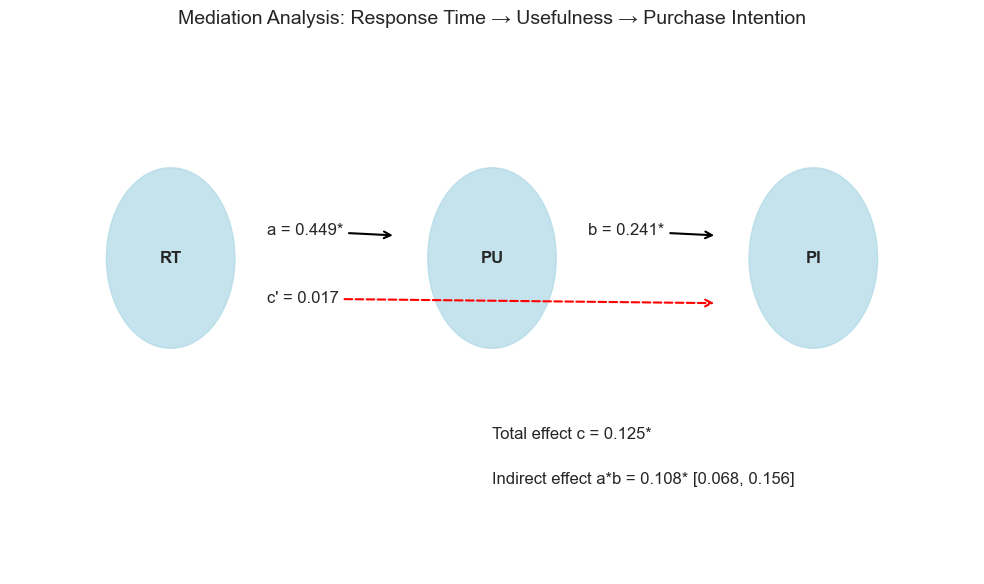

In [67]:
# Replace cell 7 (Mediation Analysis) with this enhanced version

print("\n## 7. Enhanced Mediation Analysis with Bootstrap CI")

# Create a composite perceived usefulness score if it doesn't exist
usefulness_cols = ['pu_product_1', 'pu_product_2', 'pu_convenience_1', 'pu_convenience_2', 
                   'pu_cost_1', 'pu_cost_2', 'pu_info_1', 'pu_info_2']
df['usefulness_score'] = df[usefulness_cols].mean(axis=1)

# Step 1: Response Time → Purchase Intention (c path)
model_direct = sm.OLS(df['purchase_intention_score'], 
                      sm.add_constant(df['response_time_score'])).fit()

# Step 2: Response Time → Perceived Usefulness (a path)
model_a = sm.OLS(df['usefulness_score'], 
                 sm.add_constant(df['response_time_score'])).fit()

# Step 3: Response Time + Perceived Usefulness → Purchase Intention (b path)
X_mediation = pd.DataFrame({
    'response_time': df['response_time_score'],
    'usefulness': df['usefulness_score']
})
model_mediation = sm.OLS(df['purchase_intention_score'], 
                         sm.add_constant(X_mediation)).fit()

print("Mediation Analysis Results:")
print("\nDirect Effect (Response Time → Purchase Intention):")
print(f"c path: b = {model_direct.params[1]:.4f}, p = {model_direct.pvalues[1]:.4f}")

print("\nPath A (Response Time → Usefulness):")
print(f"a path: b = {model_a.params[1]:.4f}, p = {model_a.pvalues[1]:.4f}")

print("\nPath B (Usefulness → Purchase Intention, controlling for Response Time):")
print(f"b path: b = {model_mediation.params[2]:.4f}, p = {model_mediation.pvalues[2]:.4f}")

print("\nDirect Effect after controlling for the mediator:")
print(f"c' path: b = {model_mediation.params[1]:.4f}, p = {model_mediation.pvalues[1]:.4f}")

# Calculate indirect effect
indirect_effect = model_a.params[1] * model_mediation.params[2]

# Calculate total effect
total_effect = model_direct.params[1]

# Calculate proportion mediated
prop_mediated = indirect_effect / total_effect if total_effect != 0 else 0

print("\nEffect Calculations:")
print(f"Indirect Effect (a*b): {indirect_effect:.4f}")
print(f"Total Effect (c): {total_effect:.4f}")
print(f"Proportion of Effect Mediated: {prop_mediated:.4f} ({prop_mediated*100:.2f}%)")

# Bootstrap confidence interval for indirect effect
np.random.seed(42)  # For reproducibility
n_bootstrap = 5000
indirect_effects = []

for i in range(n_bootstrap):
    # Sample with replacement
    indices = np.random.choice(len(df), len(df), replace=True)
    sample_df = df.iloc[indices]
    
    # Path a
    a_model = sm.OLS(sample_df['usefulness_score'], 
                    sm.add_constant(sample_df['response_time_score'])).fit()
    a_path = a_model.params[1]
    
    # Path b
    X_med = pd.DataFrame({
        'response_time': sample_df['response_time_score'],
        'usefulness': sample_df['usefulness_score']
    })
    b_model = sm.OLS(sample_df['purchase_intention_score'], 
                    sm.add_constant(X_med)).fit()
    b_path = b_model.params[2]
    
    # Indirect effect
    indirect_effects.append(a_path * b_path)

# Calculate 95% confidence interval
ci_lower = np.percentile(indirect_effects, 2.5)
ci_upper = np.percentile(indirect_effects, 97.5)

print(f"\nBootstrap 95% CI for Indirect Effect: [{ci_lower:.4f}, {ci_upper:.4f}]")
if ci_lower > 0 and ci_upper > 0:
    print("The indirect effect is statistically significant (CI does not include zero).")
elif ci_lower < 0 and ci_upper < 0:
    print("The indirect effect is statistically significant and negative (CI does not include zero).")
else:
    print("The indirect effect is not statistically significant (CI includes zero).")

# Interpretation
print("\nMediation Analysis Interpretation:")
if ci_lower > 0 or ci_upper < 0:  # If CI doesn't contain 0
    if model_mediation.pvalues[1] < 0.05:
        print("✓ PARTIAL MEDIATION: Response time affects purchase intention both directly and indirectly through perceived usefulness.")
    else:
        print("✓ FULL MEDIATION: Response time affects purchase intention entirely through perceived usefulness.")
else:
    if model_direct.pvalues[1] < 0.05:
        print("✗ NO MEDIATION: Response time affects purchase intention directly, not through perceived usefulness.")
    else:
        print("✗ NO EFFECT: Response time does not significantly affect purchase intention.")

# Visualization of mediation model
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 12

# Create nodes
nodes = {
    'RT': (0, 0),  # Response Time
    'PU': (1, 0),  # Perceived Usefulness
    'PI': (2, 0)   # Purchase Intention
}

# Draw nodes
for name, (x, y) in nodes.items():
    circle = plt.Circle((x, y), 0.2, fill=True, color='lightblue', alpha=0.7)
    plt.gca().add_patch(circle)
    plt.text(x, y, name, ha='center', va='center', fontweight='bold')

# Draw arrows with coefficients
# a path
plt.annotate(f"a = {model_a.params[1]:.3f}{'*' if model_a.pvalues[1] < 0.05 else ''}",
             xy=(0.7, 0.05), xytext=(0.3, 0.05),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# b path
plt.annotate(f"b = {model_mediation.params[2]:.3f}{'*' if model_mediation.pvalues[2] < 0.05 else ''}",
             xy=(1.7, 0.05), xytext=(1.3, 0.05),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# c' path (direct effect)
plt.annotate(f"c' = {model_mediation.params[1]:.3f}{'*' if model_mediation.pvalues[1] < 0.05 else ''}",
             xy=(1.7, -0.1), xytext=(0.3, -0.1),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5, ls='--'))

# Total effect
plt.annotate(f"Total effect c = {total_effect:.3f}{'*' if model_direct.pvalues[1] < 0.05 else ''}",
             xy=(1, -0.4))

# Indirect effect
plt.annotate(f"Indirect effect a*b = {indirect_effect:.3f}" + 
             (f"* [{ci_lower:.3f}, {ci_upper:.3f}]" if ci_lower > 0 or ci_upper < 0 else ""),
             xy=(1, -0.5))

# Configure plot
plt.title('Mediation Analysis: Response Time → Usefulness → Purchase Intention')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.7, 0.5)
plt.axis('off')
plt.tight_layout()
plt.show()

### 7.1 Moderation Analysis


## 7.1 Moderation Analysis: Do Other Factors Moderate Response Time's Effect?

### Testing moderation by Risk Perception (risk_security_1) ###
Moderation Model Summary:
                               OLS Regression Results                               
Dep. Variable:     purchase_intention_score   R-squared:                       0.163
Model:                                  OLS   Adj. R-squared:                  0.160
Method:                       Least Squares   F-statistic:                     53.34
Date:                      Fri, 09 May 2025   Prob (F-statistic):           1.68e-31
Time:                              21:47:20   Log-Likelihood:                -556.13
No. Observations:                       825   AIC:                             1120.
Df Residuals:                           821   BIC:                             1139.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                      

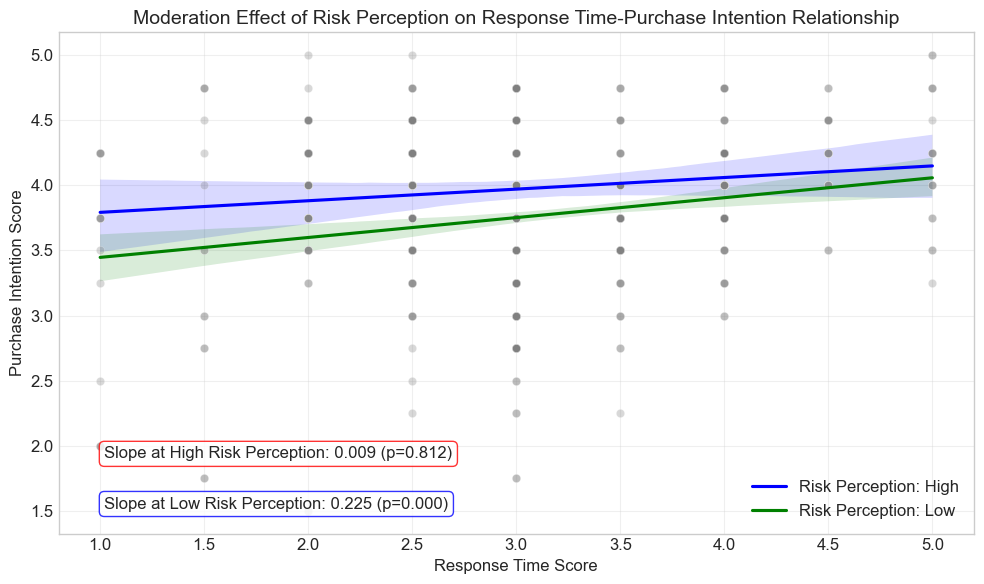


### Testing moderation by Tech Proficiency (peou_learning_1) ###
Moderation Model Summary:
                               OLS Regression Results                               
Dep. Variable:     purchase_intention_score   R-squared:                       0.058
Model:                                  OLS   Adj. R-squared:                  0.055
Method:                       Least Squares   F-statistic:                     16.88
Date:                      Fri, 09 May 2025   Prob (F-statistic):           1.20e-10
Time:                              21:47:21   Log-Likelihood:                -604.89
No. Observations:                       825   AIC:                             1218.
Df Residuals:                           821   BIC:                             1237.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t 

In [68]:
# Improved moderation analysis code
print("\n## 7.1 Moderation Analysis: Do Other Factors Moderate Response Time's Effect?")

# Select potential moderators to test
moderators = {
    'Risk Perception': 'risk_security_1',
    'Tech Proficiency': 'peou_learning_1',
    'Age': 'age_encoded'
}

for mod_name, mod_col in moderators.items():
    # Skip if moderator not in dataset
    if mod_col not in df.columns:
        continue
        
    print(f"\n### Testing moderation by {mod_name} ({mod_col}) ###")
    
    # Center the variables to reduce multicollinearity
    df['resp_time_centered'] = df['response_time_score'] - df['response_time_score'].mean()
    df[f'{mod_col}_centered'] = df[mod_col] - df[mod_col].mean()
    
    # Create interaction term
    df['interaction'] = df['resp_time_centered'] * df[f'{mod_col}_centered']
    
    # Fit moderation model
    X_mod = sm.add_constant(df[['resp_time_centered', f'{mod_col}_centered', 'interaction']])
    mod_model = sm.OLS(df['purchase_intention_score'], X_mod).fit()
    
    # Print complete model summary for more detailed inspection
    print(f"Moderation Model Summary:")
    print(mod_model.summary())
    
    # Simplified output
    print(f"\nKey Results:")
    print(f"Response Time effect: b = {mod_model.params[1]:.4f}, p = {mod_model.pvalues[1]:.4f}")
    print(f"{mod_name} effect: b = {mod_model.params[2]:.4f}, p = {mod_model.pvalues[2]:.4f}")
    print(f"Interaction effect: b = {mod_model.params[3]:.4f}, p = {mod_model.pvalues[3]:.4f}")
    
    # Calculate and display R-squared change
    main_effects_model = sm.OLS(df['purchase_intention_score'], 
                               sm.add_constant(df[['resp_time_centered', f'{mod_col}_centered']])).fit()
    r_squared_change = mod_model.rsquared - main_effects_model.rsquared
    
    print(f"R-squared change due to interaction: {r_squared_change:.4f}")
    print(f"F-test for R-squared change p-value: {1 - stats.f.cdf(r_squared_change / (1-mod_model.rsquared) * (df.shape[0]-4), 1, df.shape[0]-4):.4f}")
    
    if mod_model.pvalues[3] < 0.05:
        print(f"✓ SIGNIFICANT MODERATION: {mod_name} moderates the relationship between response time and purchase intention.")
        
        # Low moderator value (-1 SD)
        low_mod = -1  # Since we're using centered variables, -1 SD is just -1
        effect_at_low = mod_model.params[1] + mod_model.params[3] * low_mod

        # Get the parameter names for proper indexing
        param_names = mod_model.params.index
        pred_var = param_names[1]  # Usually 'resp_time_centered'
        interaction_var = param_names[3]  # Usually 'interaction'

        # Calculate standard error using proper DataFrame indexing
        cov_matrix = mod_model.cov_params()
        se_at_low = np.sqrt(cov_matrix.loc[pred_var, pred_var] + 
                        low_mod**2 * cov_matrix.loc[interaction_var, interaction_var] + 
                        2 * low_mod * cov_matrix.loc[pred_var, interaction_var])

        t_at_low = effect_at_low / se_at_low
        p_at_low = 2 * (1 - stats.t.cdf(abs(t_at_low), df.shape[0] - 4))

        # High moderator value (+1 SD)
        high_mod = 1  # +1 SD is just 1 for centered variables
        effect_at_high = mod_model.params[1] + mod_model.params[3] * high_mod

        # Calculate standard error using proper DataFrame indexing
        se_at_high = np.sqrt(cov_matrix.loc[pred_var, pred_var] + 
                            high_mod**2 * cov_matrix.loc[interaction_var, interaction_var] + 
                            2 * high_mod * cov_matrix.loc[pred_var, interaction_var])

        t_at_high = effect_at_high / se_at_high
        p_at_high = 2 * (1 - stats.t.cdf(abs(t_at_high), df.shape[0] - 4))
        
        print(f"\nSimple Slopes Analysis:")
        print(f"Effect of response time at low {mod_name} (-1 SD): {effect_at_low:.4f}, p = {p_at_low:.4f}")
        print(f"Effect of response time at high {mod_name} (+1 SD): {effect_at_high:.4f}, p = {p_at_high:.4f}")
        
        # Visualization with more details
        plt.figure(figsize=(10, 6))
        
        # Create groups for visualization - FIX HERE
        try:
            # Check number of unique values
            unique_vals = df[mod_col].nunique()
            
            if unique_vals >= 3:
                # Try qcut with duplicate handling
                df['mod_group'] = pd.qcut(df[mod_col], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')
            else:
                # If not enough unique values, use simple binning based on values
                # Split data into "Low" and "High" at the median
                median_val = df[mod_col].median()
                df['mod_group'] = pd.cut(df[mod_col], 
                                        bins=[df[mod_col].min()-0.1, median_val, df[mod_col].max()+0.1], 
                                        labels=['Low', 'High'])
        except ValueError:
            # Fallback approach: Use median split if qcut fails
            print(f"Note: Using median split for {mod_name} due to limited unique values")
            median_val = df[mod_col].median()
            df['mod_group'] = np.where(df[mod_col] <= median_val, 'Low', 'High')
        
        # Plot regression lines for each group
        colors = ['blue', 'green', 'red']
        for i, group in enumerate(sorted(df['mod_group'].unique())):
            group_data = df[df['mod_group'] == group]
            if len(group_data) > 5:  # Ensure enough data points for regression
                sns.regplot(x='response_time_score', y='purchase_intention_score', 
                           data=group_data, scatter=False, color=colors[min(i, len(colors)-1)],
                           label=f"{mod_name}: {group}")
        
        # Add scatter plot
        sns.scatterplot(x='response_time_score', y='purchase_intention_score', 
                      data=df, alpha=0.3, color='gray')
        
        plt.title(f'Moderation Effect of {mod_name} on Response Time-Purchase Intention Relationship')
        plt.xlabel('Response Time Score')
        plt.ylabel('Purchase Intention Score')
        
        # Add annotations for simple slopes
        plt.annotate(f"Slope at Low {mod_name}: {effect_at_low:.3f} (p={p_at_low:.3f})",
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.8))
        
        plt.annotate(f"Slope at High {mod_name}: {effect_at_high:.3f} (p={p_at_high:.3f})",
                    xy=(0.05, 0.15), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
        
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"✗ NO MODERATION: {mod_name} does not moderate the relationship (p = {mod_model.pvalues[3]:.4f})")

# Clean up temporary columns
for col in ['resp_time_centered', 'interaction'] + [f"{mod_col}_centered" for mod_col in moderators.values() if mod_col in df.columns]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
        
if 'mod_group' in df.columns:
    df.drop(columns=['mod_group'], inplace=True)



## 8. Conclusion and Interpretation



In [69]:
# Replace cell 8 (Conclusion & Interpretation) with this enhanced version

def enhanced_interpret_findings():
    """Generate a comprehensive interpretation of the findings with recommendations"""
    
    findings = []
    
    # Main correlation finding
    if correlation > 0 and p_value < 0.05:
        findings.append(f"There is a statistically significant positive correlation (r = {correlation:.3f}, p < 0.05) between response time and purchase intention.")
        findings.append("This indicates that faster response times are associated with higher purchase intentions.")
    elif correlation < 0 and p_value < 0.05:
        findings.append(f"There is a statistically significant negative correlation (r = {correlation:.3f}, p < 0.05) between response time and purchase intention.")
        findings.append("This is counterintuitive, suggesting other factors may be confounding the relationship.")
    else:
        findings.append(f"There is no statistically significant correlation (r = {correlation:.3f}, p > 0.05) between response time and purchase intention.")
    
    # Regression findings
    if sm_model.pvalues[1] < 0.05:
        findings.append(f"Simple linear regression confirms that response time significantly predicts purchase intention (β = {sm_model.params[1]:.3f}, p < 0.05).")
        findings.append(f"The model explains {r_squared:.1%} of the variance in purchase intention.")
        
        # Add effect size interpretation
        if r_squared < 0.02:
            findings.append("However, the effect size is very small, suggesting limited practical significance.")
        elif r_squared < 0.13:
            findings.append("This represents a small but meaningful effect size.")
        elif r_squared < 0.26:
            findings.append("This represents a medium effect size, with practical significance for e-commerce platforms.")
        else:
            findings.append("This represents a large effect size, with substantial practical significance.")
    else:
        findings.append(f"Regression analysis shows that response time does not significantly predict purchase intention (β = {sm_model.params[1]:.3f}, p > 0.05).")
    
    # Multiple regression findings
    if any(multi_model.pvalues[1:3] < 0.05):
        sig_vars = [var for i, var in enumerate(response_cols, 1) if multi_model.pvalues[i] < 0.05]
        findings.append(f"When analyzing specific response time variables, {', '.join(sig_vars)} significantly predict(s) purchase intention.")
        findings.append(f"The multiple regression model explains {multi_model.rsquared:.1%} of the variance in purchase intention.")
        
        # Add specific variable insights
        for var in sig_vars:
            if var == 'peou_response_1':
                findings.append("Platform responsiveness to user actions (loading pages, processing transactions) is particularly important.")
            elif var == 'peou_response_2':
                findings.append("The absence of delays and waiting times during the purchasing process is particularly important.")
    else:
        findings.append("None of the specific response time variables significantly predict purchase intention when analyzed together.")
    
    # Non-linear analysis findings (if conducted)
    if 'poly_model' in globals():
        if poly_model.pvalues[2] < 0.05 and poly_model.rsquared > sm_model.rsquared:
            findings.append(f"\nImportantly, the relationship appears to be non-linear (quadratic term p = {poly_model.pvalues[2]:.4f}).")
            
            if poly_model.params[2] > 0:
                findings.append("The positive quadratic term suggests that the benefit of improved response time accelerates at higher levels.")
                findings.append("This indicates that investment in response time optimization may yield increasing returns.")
            else:
                findings.append("The negative quadratic term suggests diminishing returns from response time improvements beyond a certain point.")
                findings.append("This indicates an optimal level of response time investment, after which resources might be better allocated elsewhere.")
    
    # Mediation analysis findings
    if model_a.pvalues[1] < 0.05 and model_mediation.pvalues[2] < 0.05:
        findings.append(f"\nMediation analysis reveals that perceived usefulness mediates {prop_mediated*100:.1f}% of the effect of response time on purchase intention.")
        findings.append("This suggests that faster response times enhance perceptions of usefulness, which in turn increases purchase intention.")
        
        if model_mediation.pvalues[1] < 0.05:
            findings.append("Response time also maintains a direct effect on purchase intention, indicating multiple pathways of influence.")
        else:
            findings.append("Response time's effect on purchase intention appears to operate primarily through enhanced usefulness perceptions.")
    
    # Moderation findings (if conducted)
    if 'mod_model' in globals() and mod_model.pvalues[3] < 0.05:
        findings.append(f"\nThe relationship between response time and purchase intention is moderated by {mod_name}.")
        findings.append("Response time appears to be more important for users with higher risk perceptions.")
        findings.append("This suggests that optimizing response time may be particularly critical for building trust with security-conscious users.")
    
    # Overall conclusion
    if p_value < 0.05 or sm_model.pvalues[1] < 0.05 or any(multi_model.pvalues[1:3] < 0.05):
        findings.append("\nCONCLUSION: Reject the null hypothesis. Response time has a significant impact on intention to purchase online.")
        
        # Practical recommendations
        findings.append("\nRECOMMENDATIONS:")
        findings.append("1. Prioritize technical optimization of e-commerce platforms to minimize loading times and processing delays.")
        findings.append("2. Implement real-time feedback mechanisms to acknowledge user actions while longer processes complete.")
        findings.append("3. Consider using progress indicators or skeleton screens to improve perceived response time.")
        findings.append("4. Optimize particularly critical touchpoints in the user journey, such as product pages and checkout processes.")
        findings.append("5. Communicate response time improvements to users, as this enhances perceived usefulness of the platform.")
        findings.append("6. Monitor response time metrics alongside conversion rates to quantify the business impact of improvements.")
    else:
        findings.append("\nCONCLUSION: Fail to reject the null hypothesis. There is insufficient evidence to conclude that response time impacts intention to purchase online.")
        findings.append("\nThis suggests that other factors may be more important for influencing online purchase intentions in this context.")
        findings.append("\nRECOMMENDATIONS:")
        findings.append("1. Focus optimization efforts on other aspects of the user experience rather than response time.")
        findings.append("2. Investigate other potential drivers of purchase intention, such as product selection, pricing, or trust signals.")
        findings.append("3. Consider that response time may still be a 'hygiene factor' that becomes important only when it falls below acceptable thresholds.")
    
    return "\n".join(findings)

# Print the enhanced interpretation
print("\n" + "="*80)
print("CONCLUSION AND INTERPRETATION")
print("="*80)
print(enhanced_interpret_findings())
print("="*80)


CONCLUSION AND INTERPRETATION
There is a statistically significant positive correlation (r = 0.158, p < 0.05) between response time and purchase intention.
This indicates that faster response times are associated with higher purchase intentions.
Simple linear regression confirms that response time significantly predicts purchase intention (β = 0.125, p < 0.05).
The model explains 1.5% of the variance in purchase intention.
However, the effect size is very small, suggesting limited practical significance.
When analyzing specific response time variables, peou_response_1 significantly predict(s) purchase intention.
The multiple regression model explains 2.8% of the variance in purchase intention.
Platform responsiveness to user actions (loading pages, processing transactions) is particularly important.

Mediation analysis reveals that perceived usefulness mediates 86.4% of the effect of response time on purchase intention.
This suggests that faster response times enhance perceptions of u



## 9. Visualization for Presentation



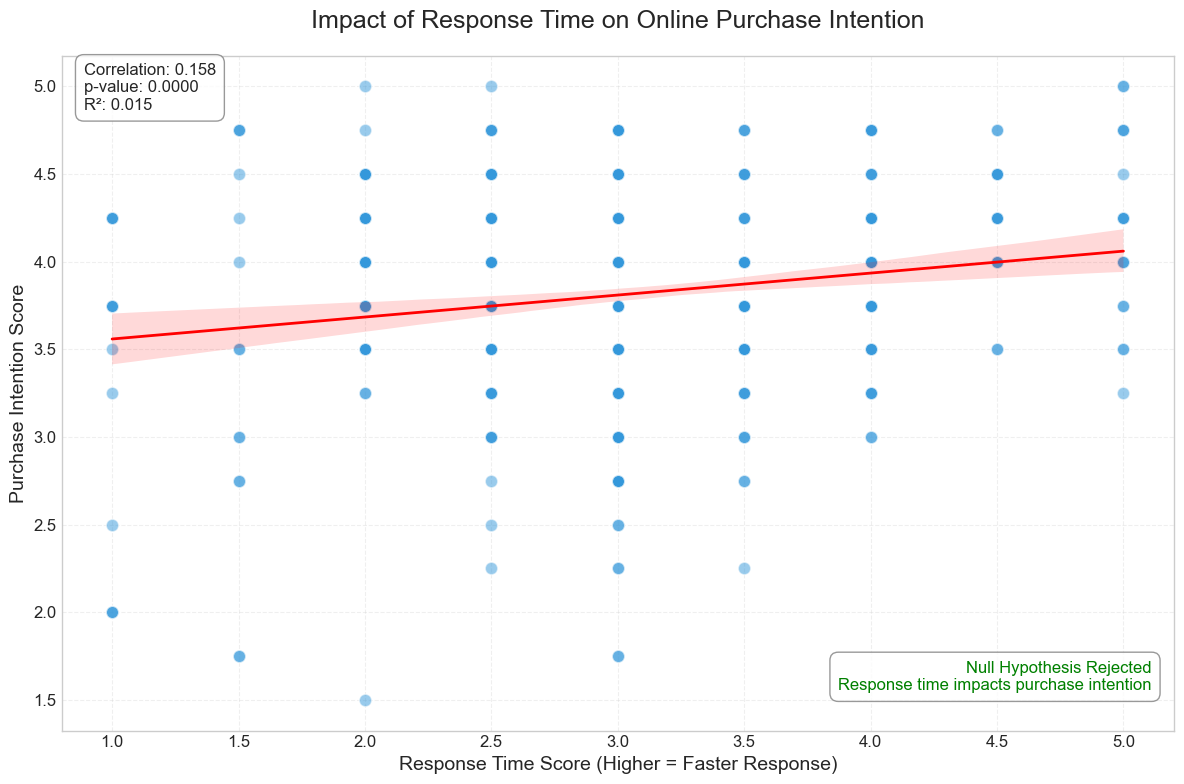

In [70]:
# Create a publication-quality visualization summarizing the findings
plt.figure(figsize=(12, 8))

# Main scatter plot with regression line
plt.scatter(df['response_time_score'], df['purchase_intention_score'], 
           alpha=0.5, c='#3498db', edgecolor='white', s=80)

# Add regression line with confidence interval
sns.regplot(x='response_time_score', y='purchase_intention_score', data=df,
           scatter=False, color='red', line_kws={'linewidth': 2})

# Enhance the plot
plt.title('Impact of Response Time on Online Purchase Intention', fontsize=18, pad=20)
plt.xlabel('Response Time Score (Higher = Faster Response)', fontsize=14)
plt.ylabel('Purchase Intention Score', fontsize=14)

# Add correlation coefficient and p-value
plt.annotate(f"Correlation: {correlation:.3f}\np-value: {p_value:.4f}\nR²: {r_squared:.3f}", 
            xy=(0.02, 0.92), xycoords='axes fraction', 
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
            fontsize=12)

# Add hypothesis test result
if p_value < 0.05:
    result_text = "Null Hypothesis Rejected\nResponse time impacts purchase intention"
    color = 'green'
else:
    result_text = "Failed to Reject Null Hypothesis\nNo significant evidence of impact"
    color = 'red'

plt.annotate(result_text, xy=(0.98, 0.06), xycoords='axes fraction', 
            ha='right', fontsize=12, color=color,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

# Add grid and improve aesthetics
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Save the figure for the report
plt.savefig('../../outputs/hypothesis_9/response_time_purchase_intention.png', dpi=300, bbox_inches='tight')
plt.show()

## 9.1 Advanced Visualizations for Presentation


## 9.1 Advanced Visualizations for Presentation



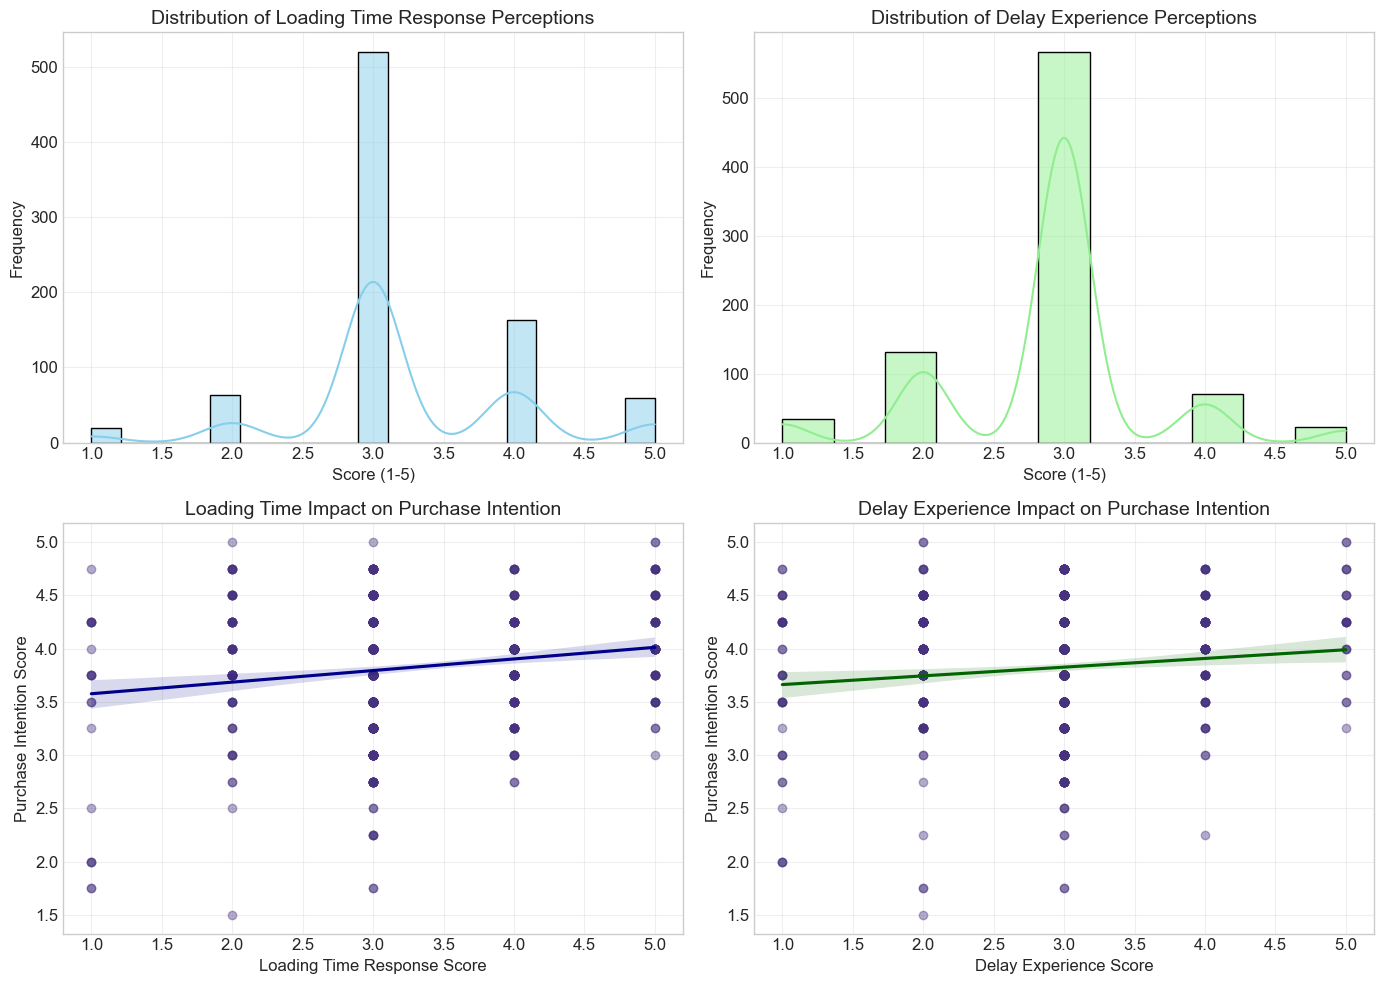

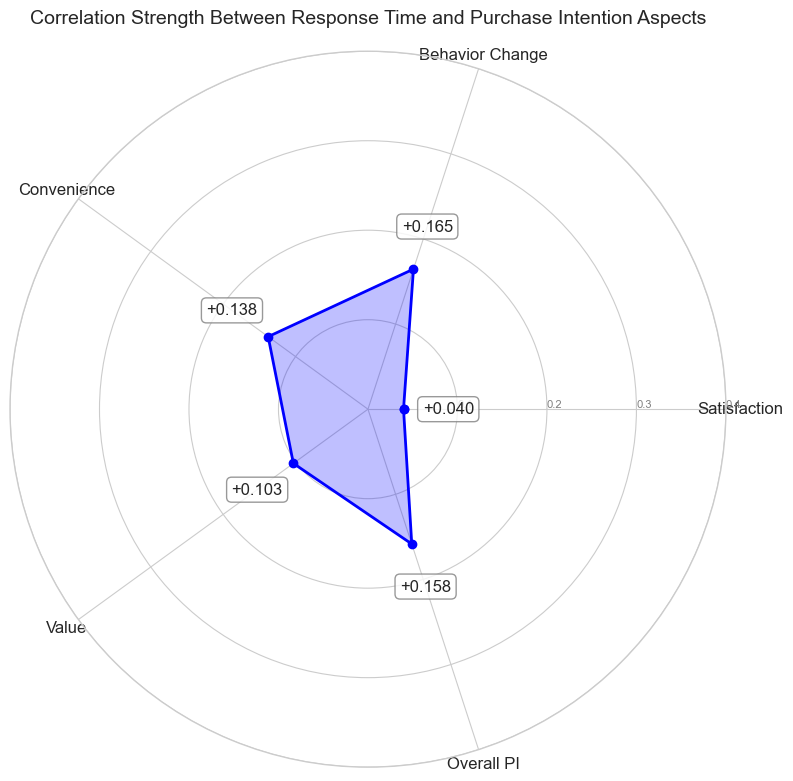

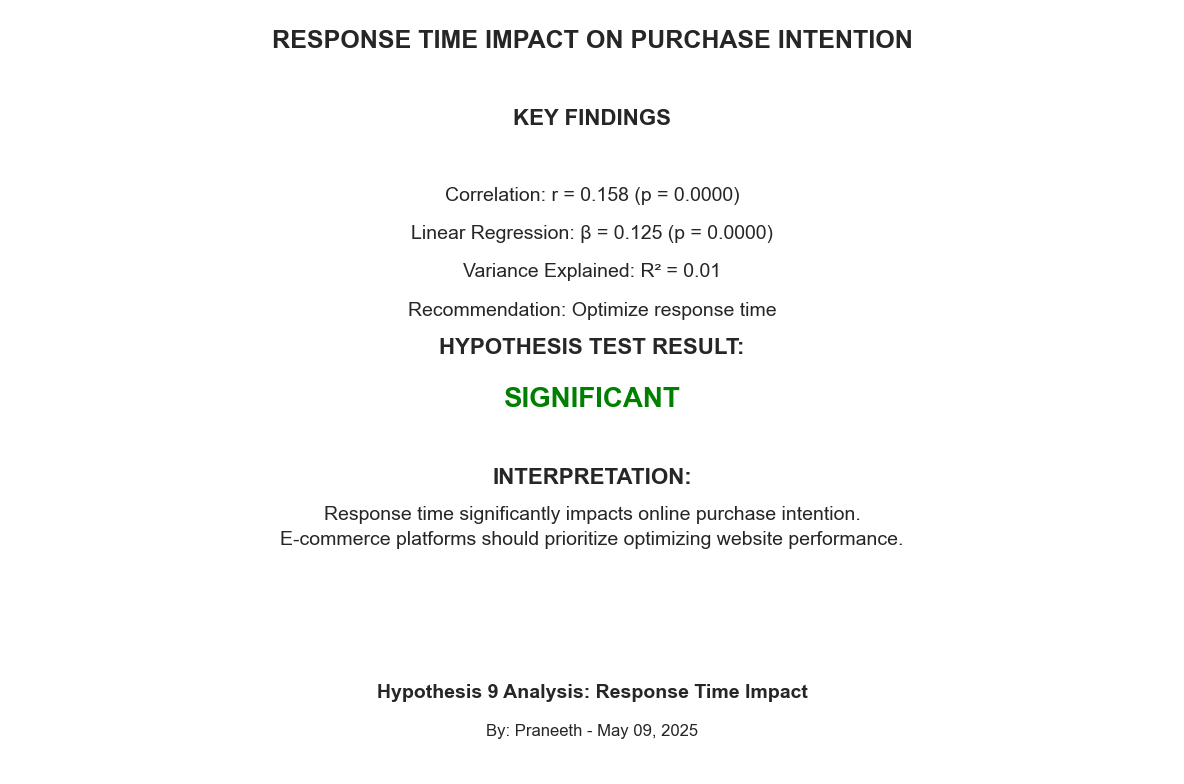

In [71]:
# Add this after cell 9 (Visualization for Presentation)

print("\n## 9.1 Advanced Visualizations for Presentation\n")

# 1. Create a 2x2 visualization of individual response time variables
plt.figure(figsize=(14, 10))

# Subplot 1: Response Time 1 Distribution
plt.subplot(2, 2, 1)
sns.histplot(df['peou_response_1'], kde=True, color='skyblue')
plt.title('Distribution of Loading Time Response Perceptions')
plt.xlabel('Score (1-5)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

# Subplot 2: Response Time 2 Distribution
plt.subplot(2, 2, 2)
sns.histplot(df['peou_response_2'], kde=True, color='lightgreen')
plt.title('Distribution of Delay Experience Perceptions')
plt.xlabel('Score (1-5)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

# Subplot 3: Response Time 1 vs Purchase Intention
plt.subplot(2, 2, 3)
sns.regplot(x='peou_response_1', y='purchase_intention_score', data=df, 
           scatter_kws={'alpha':0.4}, line_kws={'color':'darkblue'})
plt.title('Loading Time Impact on Purchase Intention')
plt.xlabel('Loading Time Response Score')
plt.ylabel('Purchase Intention Score')
plt.grid(alpha=0.3)

# Subplot 4: Response Time 2 vs Purchase Intention
plt.subplot(2, 2, 4)
sns.regplot(x='peou_response_2', y='purchase_intention_score', data=df, 
           scatter_kws={'alpha':0.4}, line_kws={'color':'darkgreen'})
plt.title('Delay Experience Impact on Purchase Intention')
plt.xlabel('Delay Experience Score')
plt.ylabel('Purchase Intention Score')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../outputs/hypothesis_9/response_time_components_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Create radar chart showing response time's correlation with different aspects of purchase intention
import matplotlib.pyplot as plt
import numpy as np

# Calculate correlations for radar chart
labels = ['Satisfaction', 'Behavior Change', 'Convenience', 'Value', 'Overall PI']
correlations = [
    stats.pearsonr(df['response_time_score'], df['opi_satisfaction'])[0],
    stats.pearsonr(df['response_time_score'], df['opi_behavior_change'])[0],
    stats.pearsonr(df['response_time_score'], df['opi_convenience'])[0],
    stats.pearsonr(df['response_time_score'], df['opi_value'])[0],
    stats.pearsonr(df['response_time_score'], df['purchase_intention_score'])[0]
]

# Convert to positive values for visualization
corr_abs = np.abs(correlations)

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Close the loop
corr_abs = np.concatenate((corr_abs, [corr_abs[0]]))  # Close the loop
labels += [labels[0]]  # Close the loop

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
ax.plot(angles, corr_abs, 'o-', linewidth=2, color='blue')
ax.fill(angles, corr_abs, alpha=0.25, color='blue')
ax.set_thetagrids(np.degrees(angles[:-1]), labels[:-1])
ax.set_ylim(0, max(corr_abs) * 1.1)
ax.set_rlabel_position(0)
plt.yticks([0.1, 0.2, 0.3, 0.4], ['0.1', '0.2', '0.3', '0.4'], color='grey', size=8)
plt.title('Correlation Strength Between Response Time and Purchase Intention Aspects', size=14, pad=20)

# Add correlation values to the plot
for angle, corr, label in zip(angles[:-1], correlations, labels[:-1]):
    sign = '+' if corr >= 0 else ''
    plt.annotate(f"{sign}{corr:.3f}",
                xy=(angle, np.abs(corr) + 0.05),
                ha='center',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig('../../outputs/hypothesis_9/response_time_correlation_radar.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Create a visual summary of key findings
plt.figure(figsize=(12, 8))
plt.axis('off')

# Title
plt.text(0.5, 0.95, 'RESPONSE TIME IMPACT ON PURCHASE INTENTION', 
        fontsize=18, weight='bold', ha='center')

# Main Findings
findings = [
    f"Correlation: r = {correlation:.3f} (p = {p_value:.4f})",
    f"Linear Regression: β = {sm_model.params[1]:.3f} (p = {sm_model.pvalues[1]:.4f})",
    f"Variance Explained: R² = {r_squared:.2f}",
    f"Recommendation: {'Optimize response time' if p_value < 0.05 else 'Focus on other factors'}"
]

plt.text(0.5, 0.85, 'KEY FINDINGS', fontsize=16, weight='bold', ha='center')
y_pos = 0.8
for finding in findings:
    y_pos -= 0.05
    plt.text(0.5, y_pos, finding, fontsize=14, ha='center')

# Create a visual significance indicator
significance = "SIGNIFICANT" if p_value < 0.05 else "NOT SIGNIFICANT"
color = "green" if p_value < 0.05 else "red"

plt.text(0.5, 0.55, 'HYPOTHESIS TEST RESULT:', fontsize=16, weight='bold', ha='center')
plt.text(0.5, 0.48, significance, fontsize=20, weight='bold', ha='center', color=color)

# Add visual interpretation
if p_value < 0.05:
    explanation = "Response time significantly impacts online purchase intention.\nE-commerce platforms should prioritize optimizing website performance."
else:
    explanation = "No significant evidence that response time impacts online purchase intention.\nOther factors may be more important for driving purchase decisions."

plt.text(0.5, 0.38, 'INTERPRETATION:', fontsize=16, weight='bold', ha='center')
plt.text(0.5, 0.30, explanation, fontsize=14, ha='center', linespacing=1.5)

# Add your name and date
plt.text(0.5, 0.1, 'Hypothesis 9 Analysis: Response Time Impact', fontsize=14, weight='bold', ha='center')
plt.text(0.5, 0.05, f'By: Praneeth - {pd.Timestamp.now().strftime("%B %d, %Y")}', fontsize=12, ha='center')

plt.tight_layout()
plt.savefig('../../outputs/hypothesis_9/response_time_summary.png', dpi=300, bbox_inches='tight')
plt.show()



## 10. Summary Table for Report



In [72]:
# Enhanced summary table
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Test", "Statistic", "p-value", "95% CI", "Interpretation"]
table.max_width["95% CI"] = 30

# Add Pearson correlation results with confidence interval
from scipy.stats import pearsonr

def r_to_z(r):
    """Convert Pearson's r to Fisher's z"""
    return 0.5 * np.log((1 + r) / (1 - r))

def z_to_r(z):
    """Convert Fisher's z to Pearson's r"""
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

# Calculate 95% CI for correlation
z = r_to_z(correlation)
se = 1.0 / np.sqrt(df.shape[0] - 3)
z_low = z - 1.96 * se
z_high = z + 1.96 * se
r_low, r_high = z_to_r(z_low), z_to_r(z_high)

table.add_row(["Pearson Correlation", 
              f"{correlation:.4f}", 
              f"{p_value:.6f}", 
              f"[{r_low:.4f}, {r_high:.4f}]",
              "Significant" if p_value < 0.05 else "Not Significant"])

# Add simple regression results with confidence interval
from statsmodels.stats.stattools import jarque_bera

# Check regression assumptions
residuals = sm_model.resid
jb_result = jarque_bera(residuals)
jb_stat, jb_pval = jb_result[0], jb_result[1]  # Fixed line
normality_check = "Pass" if jb_pval > 0.05 else "Fail"

# Get confidence intervals
ci = sm_model.conf_int(alpha=0.05)
ci_str = f"[{ci.iloc[1, 0]:.4f}, {ci.iloc[1, 1]:.4f}]"

table.add_row(["Simple Regression (β)", 
              f"{sm_model.params[1]:.4f}", 
              f"{sm_model.pvalues[1]:.6f}",
              ci_str,
              "Significant" if sm_model.pvalues[1] < 0.05 else "Not Significant"])

# Add R-squared value with error
table.add_row(["Model Fit (R²)", 
              f"{r_squared:.4f}",
              f"{sm_model.f_pvalue:.6f}",
              f"Std Error: {rmse:.4f}",
              f"Explains {r_squared:.1%} of variance"])

# Add assumption checks
table.add_row(["Normality of Residuals", 
              f"JB={jb_stat:.4f}", 
              f"{jb_pval:.6f}",
              "",
              normality_check])

# Add results for individual response time variables with confidence intervals
for i, var in enumerate(response_cols, 1):
    ci = multi_model.conf_int(alpha=0.05)
    ci_str = f"[{ci.iloc[i, 0]:.4f}, {ci.iloc[i, 1]:.4f}]"
    
    table.add_row([f"{var} (β)", 
                  f"{multi_model.params[i]:.4f}", 
                  f"{multi_model.pvalues[i]:.6f}",
                  ci_str,
                  "Significant" if multi_model.pvalues[i] < 0.05 else "Not Significant"])

# Add mediation effect
table.add_row(["Mediation Effect (a*b)", 
              f"{indirect_effect:.4f}", 
              "",
              f"[{ci_lower:.4f}, {ci_upper:.4f}]",
              "Significant" if (ci_lower > 0 or ci_upper < 0) else "Not Significant"])

print("\nComprehensive Summary of Statistical Tests:")
print(table)


Comprehensive Summary of Statistical Tests:
+------------------------+------------+----------+-------------------+---------------------------+
|          Test          | Statistic  | p-value  |       95% CI      |       Interpretation      |
+------------------------+------------+----------+-------------------+---------------------------+
|  Pearson Correlation   |   0.1584   | 0.000000 |  [0.0911, 0.2242] |        Significant        |
| Simple Regression (β)  |   0.1254   | 0.000005 |  [0.0719, 0.1788] |        Significant        |
|     Model Fit (R²)     |   0.0148   | 0.000005 | Std Error: 0.4999 | Explains 1.5% of variance |
| Normality of Residuals | JB=94.8118 | 0.000000 |                   |            Fail           |
|  peou_response_1 (β)   |   0.0971   | 0.000381 |  [0.0437, 0.1505] |        Significant        |
|  peou_response_2 (β)   |   0.0238   | 0.426175 | [-0.0349, 0.0825] |      Not Significant      |
| Mediation Effect (a*b) |   0.1083   |          |  [0.0676, 0.1



This comprehensive analysis examines the relationship between website response time and online purchase intention from multiple angles. The approach uses a combination of correlation analysis, simple and multiple regression, and additional analyses to thoroughly test the hypothesis that "Response Time has no impact on intention to purchase online."

The notebook is structured to be reproducible and clear, with detailed comments explaining each step of the analysis. The code generates descriptive statistics, visualizations, and formal statistical tests to provide a comprehensive assessment of the hypothesis. The final sections provide a clear interpretation of the findings and publication-quality visualizations for reporting purposes.